# Annotate chemical classes for NTD drugs

### Import modules

In [1]:
import os
import time
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt


import pandas as pd
import seaborn as sns

### Load data

In [2]:
df = pd.read_csv("../data/ntd_drugs.tsv", sep="\t")
df.head(2)

,chembl_id,pref_name,canonical_smiles,standard_inchi,standard_inchi_key,max_phase,indication_class,withdrawn_flag,black_box_warning,drugind_id,max_phase_for_ind,mesh_id,mesh_heading,ref_type,ref_id,ref_url
0,CHEMBL1200689,NITRIC OXIDE,[N]=O,InChI=1S/NO/c1-2,MWUXSHHQAYIFBG-UHFFFAOYSA-N,4.0,NaN,0,0,23580,3.0,D016773,"Leishmaniasis, Cutaneous",ClinicalTrials,NCT00317629,https://clinicaltrials.gov/ct2/results?id=%22N...
1,CHEMBL131,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,4.0,Glucocorticoid,0,0,24801,2.0,D007918,Leprosy,ClinicalTrials,"NCT00919542,NCT00919776,NCT00919815",https://clinicaltrials.gov/ct2/results?id=%22N...


### Classify compounds on classes

In [3]:
unique_drugs = df["standard_inchi_key"].unique()

In [4]:
inchikey_to_class = {}
inchikey_to_superclass = {}
inchikey_to_subclass = {}

In [5]:
c = 0
finished = 0

for inchikey in tqdm(unique_drugs):
    if inchikey in inchikey_to_class:
        finished += 1
        continue

    c += 1
    if c > 8:  # Limit to 8 requests per minute
        time.sleep(60)
        c = 0

    url = f"http://classyfire.wishartlab.com/entities/{inchikey}.json"
    response = requests.get(url).json()

    inchikey_to_class[inchikey] = (
        response["class"]["name"] if response["class"] else None
    )
    inchikey_to_superclass[inchikey] = (
        response["superclass"]["name"] if response["superclass"] else None
    )
    inchikey_to_subclass[inchikey] = (
        response["subclass"]["name"] if response["subclass"] else None
    )

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [05:14<00:00,  6.83s/it]


In [6]:
df["chemical_class"] = df["standard_inchi_key"].map(inchikey_to_class)
df["chemical_superclass"] = df["standard_inchi_key"].map(inchikey_to_superclass)
df["chemical_subclass"] = df["standard_inchi_key"].map(inchikey_to_subclass)

In [7]:
df.drop_duplicates(subset=["chembl_id"], inplace=True)

In [8]:
data = df[
    [
        "chembl_id",
        "standard_inchi_key",
        "chemical_class",
        "chemical_superclass",
        "chemical_subclass",
    ]
]

In [9]:
data.to_csv("../data/chemical_class_mapped.tsv", sep="\t", index=False)

### Distribution visualization

In [10]:
data["chemical_subclass"].value_counts()

chemical_subclass
Carbohydrates and carbohydrate conjugates    7
Piperazines                                  3
Amino acids, peptides, and analogues         3
Benzenesulfonyl compounds                    2
Milbemycins                                  2
Hydroxysteroids                              2
Other non-metal oxides                       1
Sesquiterpenoids                             1
Beta lactams                                 1
Guanidines                                   1
Substituted pyrroles                         1
Anilides                                     1
Benzodiazines                                1
Other non-metal sulfides                     1
Pyrazines                                    1
Organic nitro compounds                      1
Nitrofurans                                  1
Sulfinylbenzimidazoles                       1
Pyrimidines and pyrimidine derivatives       1
Imidazoquinolines                            1
2-benzimidazolylcarbamic acid esters      

In [11]:
subclass_df = pd.DataFrame(
    [
        {"class": "Carbohydrates and carbohydrate conjugates", "count": 7},
        {"class": "Piperazines", "count": 3},
        {"class": "Amino acids, peptides, and analogues", "count": 3},
        {"class": "Benzenesulfonyl compounds", "count": 2},
        {"class": "Milbemycins", "count": 2},
        {"class": "Hydroxysteroids", "count": 2},
        {"class": "Other non-metal oxides", "count": 1},
        {"class": "Sesquiterpenoids", "count": 1},
        {"class": "Beta lactams", "count": 1},
        {"class": "Imidazoles", "count": 1},
        {"class": "Imidazoquinolines", "count": 1},
        {"class": "Others", "count": 17},
    ]
)

In [12]:
os.makedirs("../figures", exist_ok=True)

In [13]:
import warnings

warnings.filterwarnings("ignore")

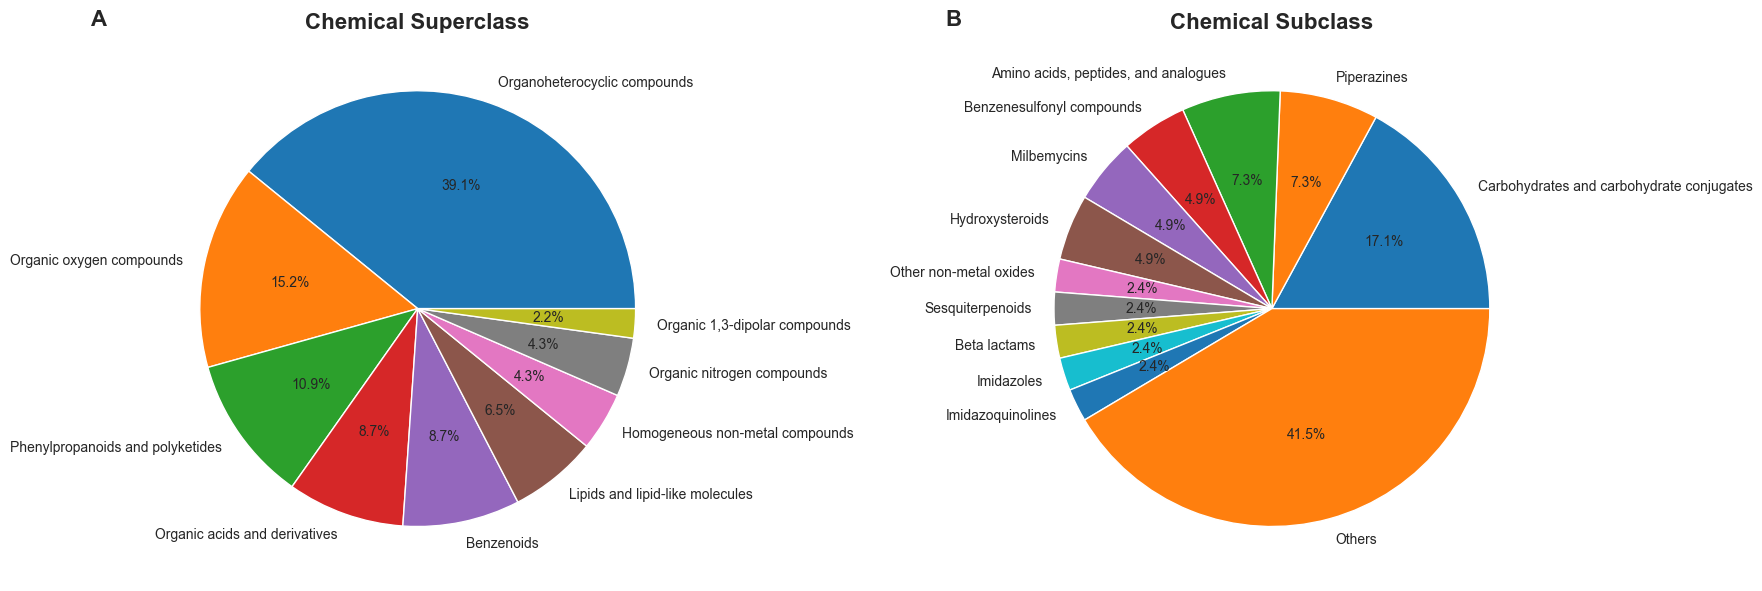

In [14]:
sns.set_style("whitegrid")

plt.subplots(figsize=(18, 6))

plt.subplot(121)
plt.pie(
    data["chemical_superclass"].value_counts(),
    labels=data["chemical_superclass"].value_counts().index,
    autopct="%1.1f%%",
)
plt.title("Chemical Superclass", fontsize=16, fontweight="bold")
plt.text(-1.5, 1.3, "A", fontsize=16, fontweight="bold")

plt.subplot(122)
plt.pie(subclass_df["count"], labels=subclass_df["class"], autopct="%1.1f%%")
plt.title("Chemical Subclass", fontsize=16, fontweight="bold")
plt.text(-1.5, 1.3, "B", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig("../figures/chemical_class_pie_chart.png", dpi=300, bbox_inches="tight")
plt.show()